# 复现DeepWalk代码并进行可视化分析

In [1]:
import networkx as nx

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import random
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_csv('seealsology-data.tsv', sep='\t')
df.head()

,source,target,depth
0,brain science,neurosemiotics,1
1,brain science,neuroscience of sex differences,1
2,brain science,gut–brain axis,1
3,brain science,connectomics,1
4,deep learning,applications of artificial intelligence,1


In [3]:
G = nx.from_pandas_edgelist(df, 'source', 'target', edge_attr=True, create_using=nx.Graph())

In [4]:
def get_randomwalk(node, path_length):
    """
    输入起始节点和路径长度，生成随机游走节点序列
    node: 当前节点
    path_length: 序列长度
    return: 随机游走节点序列
    """
    # 保存起点节点
    random_walk = [node]
    
    for i in range(path_length-1):
        # 汇总邻接节点
        temp = list(G.neighbors(node))
        temp = list(set(temp)-set(random_walk))
        
        # 如果没有邻接节点，走到一条思路就结束
        if len(temp) == 0:
            break
        
        # 选择一个邻接节点并游走过去
        random_node = random.choice(temp)
        random_walk.append(random_node)
        # 重置当前节点为游走后的新节点
        node = random_node
    
    return random_walk

In [5]:
get_randomwalk('deep learning', 5)

['deep learning',
 'cerebellar model articulation controller',
 'sparse distributed memory',
 'independent-spike coding',
 'vector quantization']

In [6]:
gamma = 10 # 每个节点作为起始节点生成随机游走序列的个数
walk_length = 5 # 游走序列的最大长度

random_walks = []

# 遍历每个节点
for n in tqdm(G):
    # 每个节点生成gamma个随机游走序列
    for i in range(gamma):
        random_walks.append(get_randomwalk(n, walk_length))

random_walks[1]

100%|██████████| 2671/2671 [00:00<00:00, 11137.05it/s]


['brain science', 'neurosemiotics', 'semiotics', 'gender symbol', 'symbol']

In [7]:
model = Word2Vec(
                vector_size=256, # embedding维度
                window=4,        # 左右窗口宽度
                sg=1,            # 使用skipgram模式
                hs=0,            # 不分层softmax
                negative=10,     # 负采样
                alpha=0.03,      # 学习率
                min_alpha=0.0007,# 最小学习率
                seed=14,         # 随机种子
)
model.build_vocab(random_walks, progress_per=2)
model.train(random_walks, total_examples=model.corpus_count, epochs=50, report_delay=1)

(4817749, 4895350)

In [8]:
# 查看每个节点的embedding
print(model.wv.get_vector('brain science'))

# 查找相似词语
print(model.wv.similar_by_word('brain science'))

[ 0.1789836  -0.01601656 -0.1996907   0.07128809  0.5648965  -0.21446608
 -0.6990095  -0.1524056  -0.03516056  0.02807834  0.5838351  -0.11424395
 -0.48155746  0.30617642 -0.39532572  0.28816873  0.53972185  0.11689249
 -0.12295786 -0.08237047 -0.15413564 -0.0622433   0.14523114  0.28081292
 -0.00795254 -0.24247687  0.57148236  0.3571459  -0.22030976 -0.18330753
 -0.33102548 -0.1774985  -0.2539843  -0.22943673  0.13428245 -0.41363615
 -0.08535191  0.50868183  0.24123582  0.07411449 -0.14368613  0.45289743
 -0.03915732 -0.18506889 -0.42693144  0.10292384 -0.08045132  0.6415428
 -0.47116157  0.47988406  0.32318723  0.42040992 -0.18367635 -0.10705714
 -0.3805628  -0.0872319  -0.3294314  -0.07107704  0.05701934 -0.23436177
 -0.15119828 -0.5214205  -0.34808934 -0.33300945 -0.30431893 -0.2992201
 -0.5065024  -0.1275089  -0.42541867 -0.10227931 -0.52259654  0.26878074
  0.00184283  0.21321644 -0.0559997  -0.24094096  0.09090327 -0.52221584
 -0.08893492 -0.63099325  0.19581433  0.22654893 -0.2

In [9]:
# 导入节点的嵌入向量
X = model.wv.vectors

pca = PCA(n_components=2) # 输入2维
embed_2d = pca.fit_transform(X)

embed_2d.shape

(2671, 2)

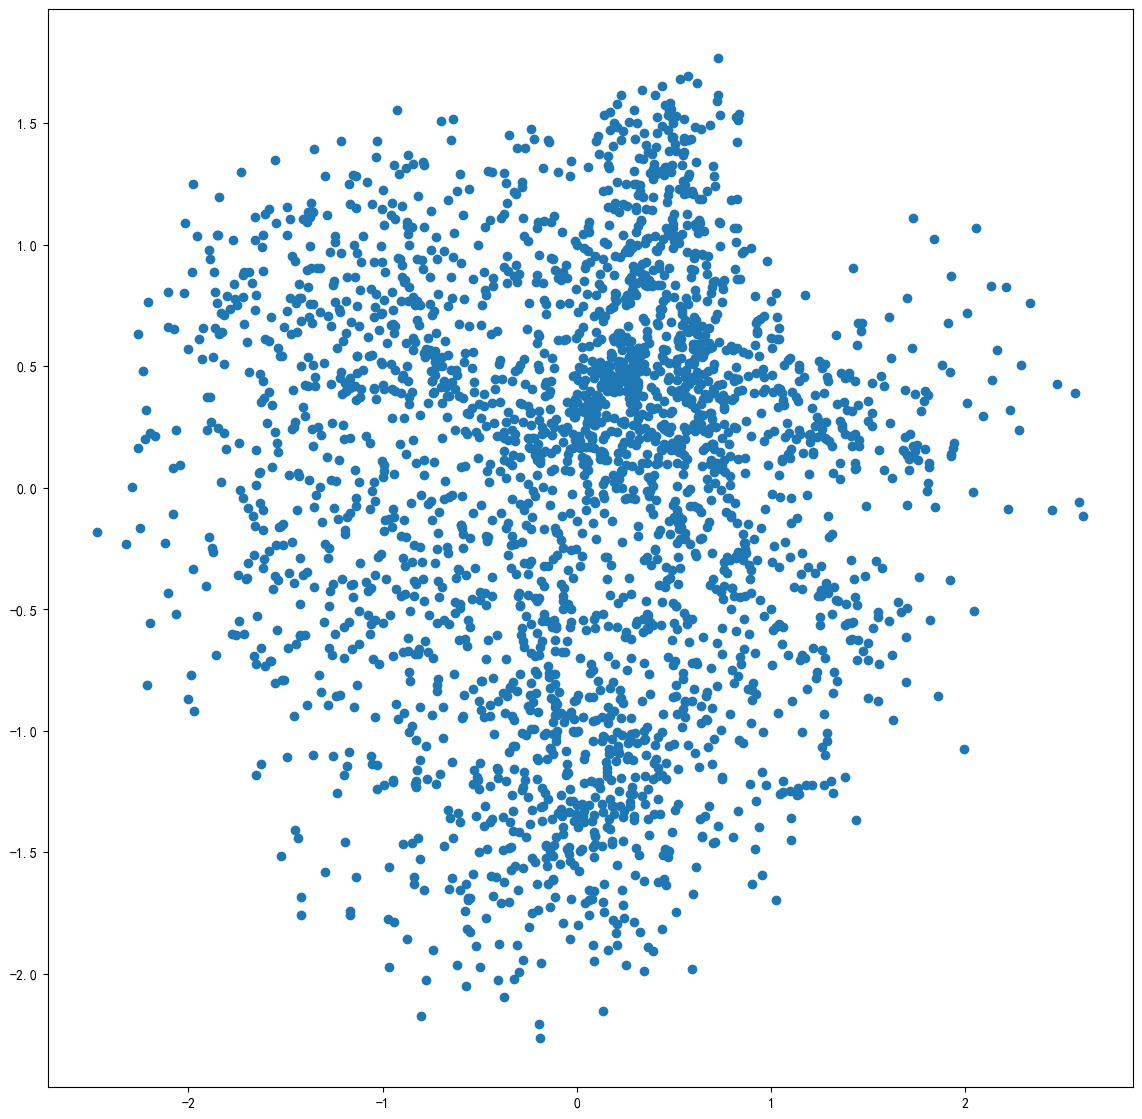

In [10]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.show()

In [11]:
pagerank = nx.pagerank(G)
node_importamce = sorted(pagerank.items(), key=lambda x:x[1], reverse=True)

# 关注前30重要的
n = 30
term_chosen = []
for each in node_importamce[:n]:
    term_chosen.append(each[0])

# 输入词条，输出词典中的索引号
term2index = model.wv.key_to_index

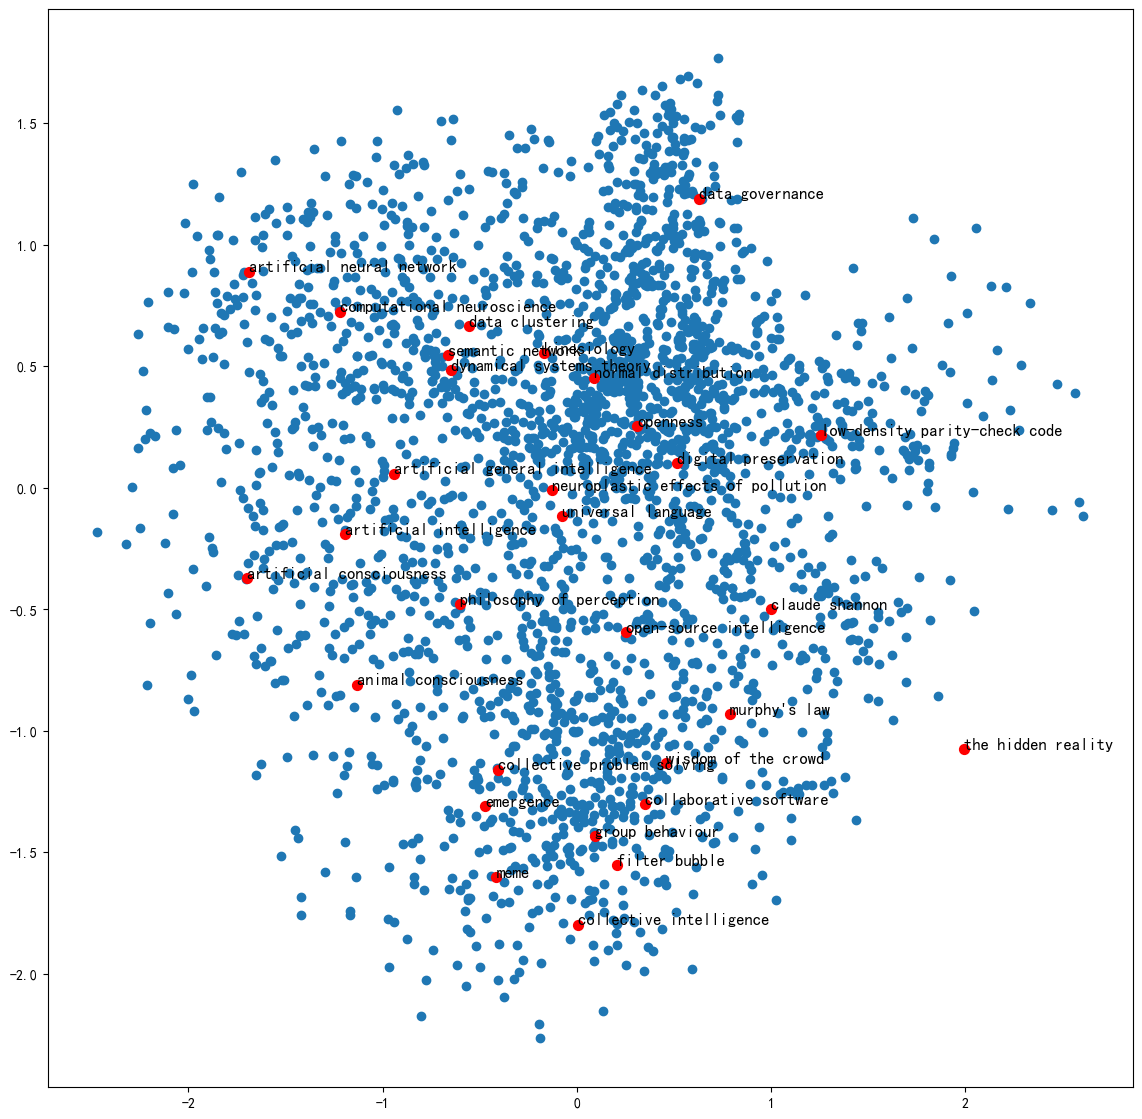

In [12]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:,0], embed_2d[:,1])

for item in term_chosen:
    idx = term2index[item]
    plt.scatter(embed_2d[idx, 0], embed_2d[idx, 1], c='r', s=50)
    plt.annotate(item, xy=(embed_2d[idx,0], embed_2d[idx,1]), c='k', fontsize=12)
plt.show()

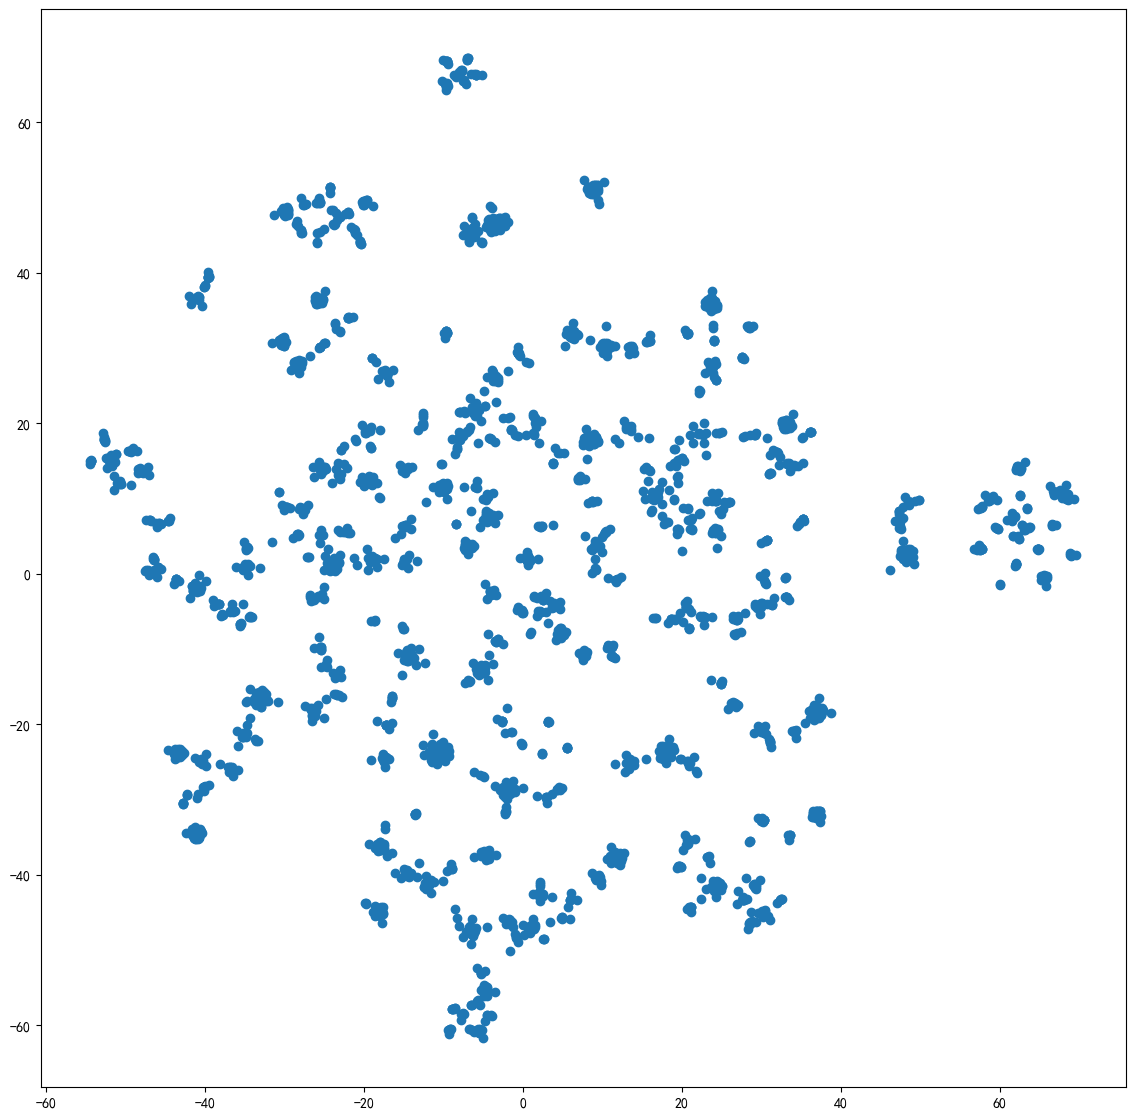

In [13]:
tsne = TSNE(n_components=2, n_iter=1000)
embed_2d = tsne.fit_transform(X)

plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:,0], embed_2d[:,1])
plt.show()

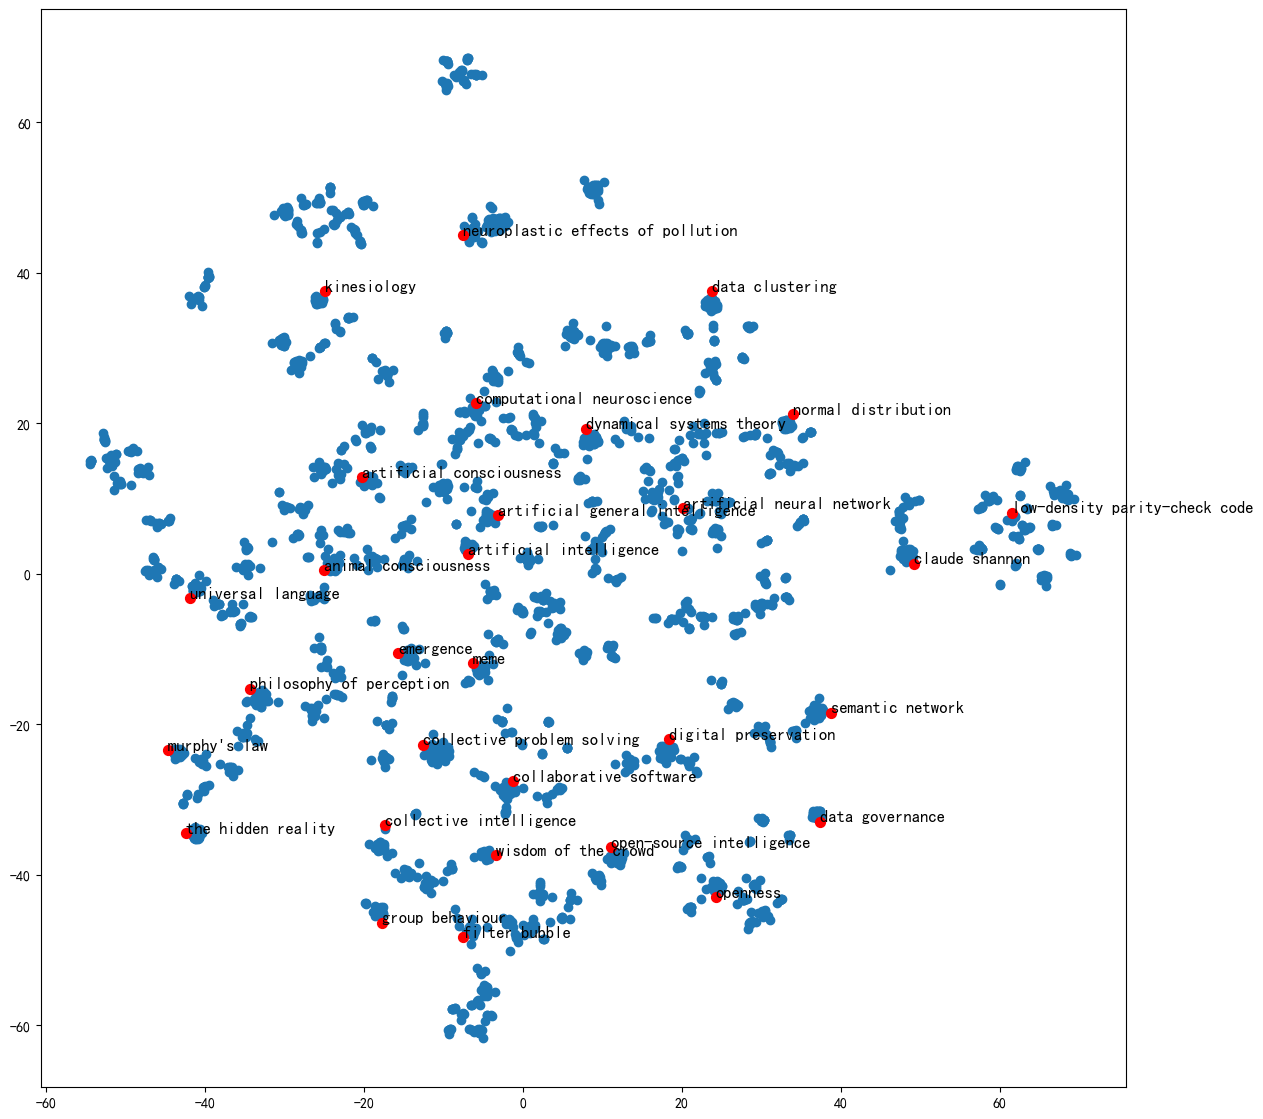

In [14]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:,0], embed_2d[:,1])

for item in term_chosen:
    idx = term2index[item]
    plt.scatter(embed_2d[idx, 0], embed_2d[idx, 1], c='r', s=50)
    plt.annotate(item, xy=(embed_2d[idx,0], embed_2d[idx,1]), c='k', fontsize=12)
plt.show()

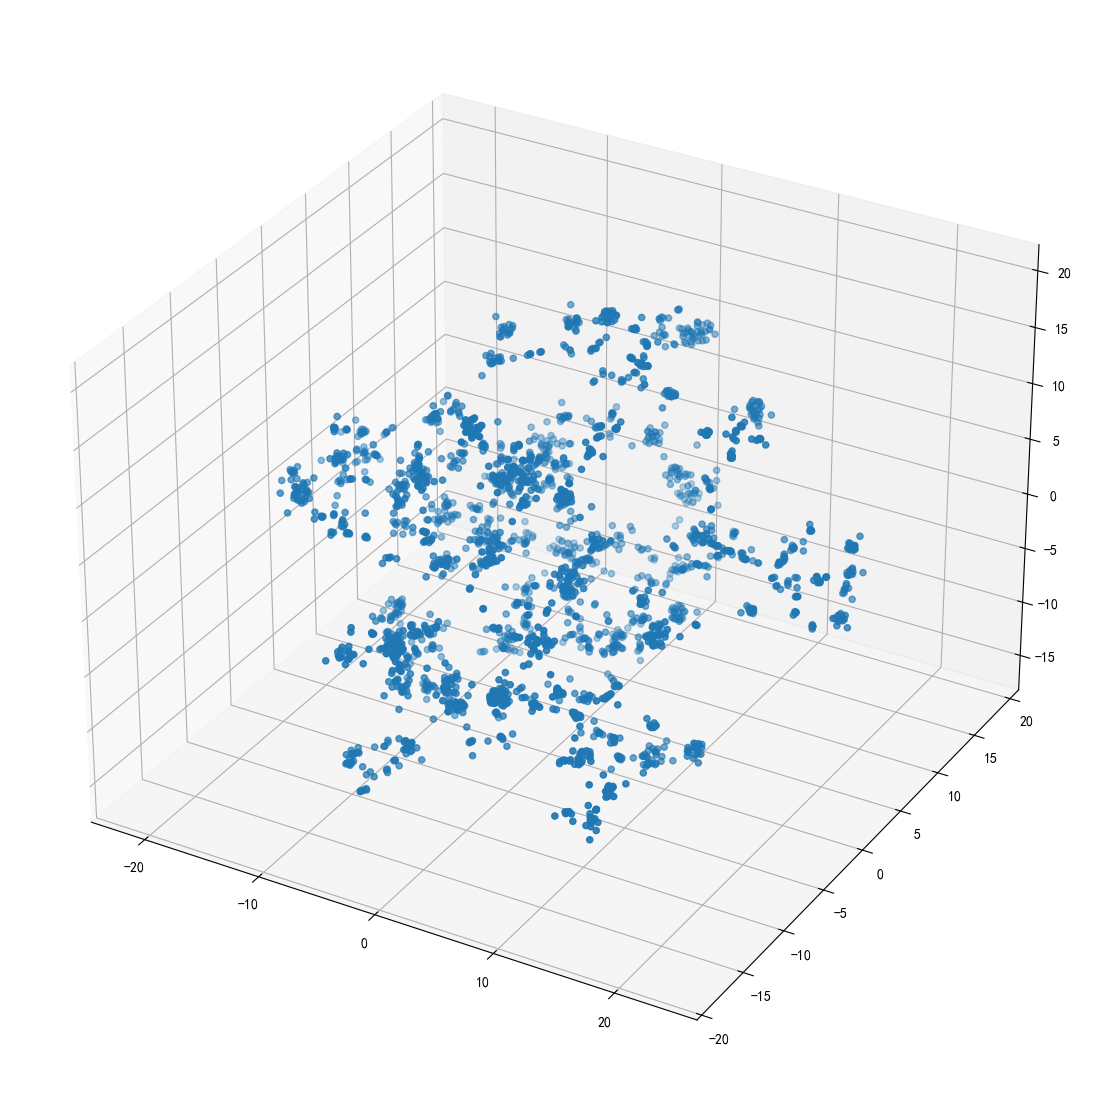

In [15]:
tsne = TSNE(n_components=3, n_iter=1000)
embed_3d = tsne.fit_transform(X)

plt.figure(figsize=(14,14))

ax = plt.axes(projection="3d")
ax.scatter3D(embed_3d[:,0], embed_3d[:,1], embed_3d[:,2])
plt.show()